<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
%load_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as matplot
import itertools
import math

from tqdm import tqdm_notebook, tqdm
from os import listdir, mkdir
from os.path import join, isdir
from ipywidgets import *
from multiprocessing import Pool, Lock

%aimport preprocessing

%autoreload 2

In [ ]:
import sys
module_path = os.path.abspath(os.path.join('../python/python_src_preprocessing/src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:


%matplotlib notebook

In [ ]:
LOGGING = False

In [4]:
def log(*args):
    if LOGGING:
        print(*args)

def load_experiment(folder, key):
    files = list(filter(lambda file: key in file, listdir(folder)))
    
    if len(files) == 0:
        return None
    
    data = pd.read_csv(
        join(folder, files[0]), 
        sep=' ', 
        names=['pedestrianId', 'timeStep', 'x', 'y', 'e'], 
        index_col=False, 
        header=None, 
        skiprows=0)
        
    data['x'] = data['x'] / 100
    data['y'] = data['y'] / 100
    
    print('loaded', files[0])
    
    return files[0], data
    
def load_multiple(path, folders, key):
    frames = []
    for folder in folders:
        frames.append(load_experiment(join(path, folder), key))
            
    return frames

In [5]:
def plot_experiment(frame, title):
    fig, ax = matplot.subplots()
    ax.set_title(title)
    
    # map p-ids to targets
    for pId, group in frame.groupby('pedestrianId'):
        ax.plot(group['x'], group['y'])
    
    ax.grid()

In [8]:
input_path = 'KO/'
output_path = 'juelich/output_test/'
experiments = [
    # 'ko-240-050-240',
    # 'ko-240-060-240',
    # 'ko-240-080-240',
    # 'ko-240-100-240',
    # 'ko-240-120-240',
    # 'ko-240-150-240',
    'ko-240-240-240',
    # 'ko-300-050-300',
    # 'ko-300-080-300',
    # 'ko-300-120-300',
    # 'ko-300-150-300'
]

# frames = load_experiment(join(input_path, experiments[0]), 'combined')

# frames = load_multiple(input_path, experiments, 'combined')

if not isdir(output_path):
    mkdir(output_path)

loaded ko-240-240-240_combined_MB.txt


<IPython.core.display.Javascript object>


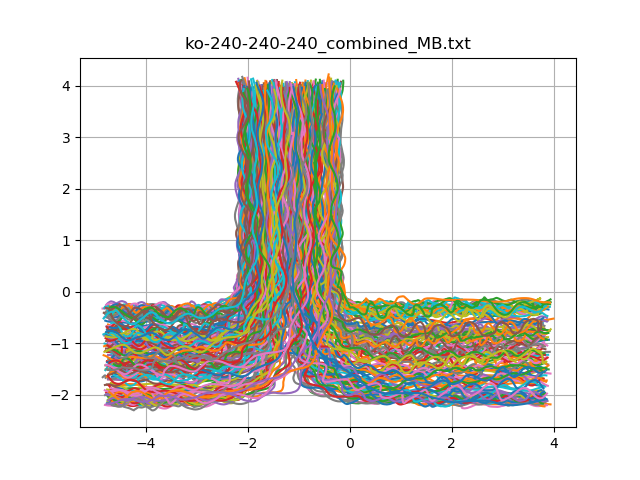

In [9]:
%matplotlib notebook

for experiment in experiments:
    filename, frame = load_experiment(join(input_path, experiment), 'combined')
    plot_experiment(frame, filename)

In [ ]:

results = []
for experiment in tqdm_notebook(experiments, desc='process files'):
    # plot_experiment(frame, experiment)
    filename, frame = load_experiment(join(input_path, experiment), 'combined')
    name = filename[:filename.index('.')]
    context = dict({
        'name': name,
        'targets': ['A', 'B', 'C'],
        'area':  [-2.4, 3, 2.4, 1],
        'exact': True,
        'sigma': 0.7,
        'resolution': 0.1,
        'pedestrian_radius': 0.195,
        'gauss_bounds': 2,
        'pId2Target': preprocessinge.juelich_assign_target,
        'processors': [
            preprocessinge.process_densities,
            preprocessinge.process_pedestrians,
            preprocessinge.process_percentiles
        ]
    })
    context = preprocessinge.process_experiment(frame, context)
    results.append(context)
    
    '''
    densities = context.get('densities')
    with open(join(output_path, name + '.csv'), mode='w') as file:
        for density in densities:
            file.write(';'.join(map(lambda r: "{:.10f}".format(r), density)) + '\n')
        
        file.flush()
    '''
    
    
'''
for result in tqdm_notebook(results, desc='saving density files'):
    name = result.get('name')
    densities = result.get('densities')
    
    with open(join(output_path, name + '.csv'), mode='w') as file:
        for density in densities:
            file.write(';'.join(map(lambda r: "{:.10f}".format(r), density)) + '\n')
        
        file.flush()
'''

In [ ]:
def extrac_xy(pedestrians, x0, y0, resolution):
    x = []
    y = []
    
    for _, ped in pedestrians.iterrows():
        x.append(int(abs(ped['x'] - x0) * ( 1 / resolution)))
        y.append(int(abs(ped['y'] - y0) * ( 1 / resolution)))
    
    return x, y
        

for result in tqdm_notebook(results, desc='process results'):
    name = result.get('name')
    densities = result.get('densities')
    area = context.get('area')
    peds = context.get('pedestrians')
    size = result.get('size')
    res = result.get('resolution')
    
    start = 12
    
    first = densities[start][:-3].reshape(size)
    #first = first / np.max(first)
    
    fig, ax = matplot.subplots()
    
    #img = ax.imshow(first, interpolation='Nearest')
    cbar = None #fig.colorbar(img)
    
    #x, y = extrac_xy(peds[0], area[0], area[1], res)

    #pl = ax.plot(x, y, '.r', markersize=10)
    
    ax.set_xticks(np.linspace(0, len(first[0]) - 1, 13))
    ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
    
    ax.set_yticks(np.linspace(0, len(first) - 1, 6))
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    
    
    
    def update(frame):
        global cbar
        f = densities[frame][:-3].reshape(size)
        
        ax.clear()
        if cbar is not None:
            cbar.remove()
        
        img = ax.imshow(f, interpolation='Nearest')
        cbar = fig.colorbar(img)

        x, y = extrac_xy(peds[frame], area[0], area[1], res)
        print(list(zip(x, y)))
        ax.plot(x, y, '.r', markersize=10)

        ax.set_xticks(np.linspace(0, len(first[0]) - 1, 13))
        ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

        ax.set_yticks(np.linspace(0, len(first) - 1, 6))
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        

    interact(update, frame=widgets.IntSlider(min=0, max=len(densities)-1, step=1, value=start));
    
    break
    
    

In [ ]:
print([type(result) for result in results])

In [17]:
output_path = 'juelich/output_01/'
outputs = os.listdir(output_path)
dfs = []
for output in outputs:
    dfs.append(pd.read_csv(os.path.join(output_path, output), sep=';', header=None))
    
frame = pd.concat([df.iloc[:,-3:] for df in dfs], sort=False)
display(frame.groupby([230, 231, 232], as_index=False).size().to_frame('frames').reset_index())

,230,231,232,frames
0,0.000000,1.000000,0.0,1372
1,0.166667,0.833333,0.0,11
2,0.200000,0.800000,0.0,45
3,0.250000,0.750000,0.0,294
4,0.285714,0.714286,0.0,3
5,0.333333,0.666667,0.0,881
6,0.400000,0.600000,0.0,517
7,0.428571,0.571429,0.0,20
8,0.500000,0.500000,0.0,1122
9,0.571429,0.428571,0.0,23
